In this notebook, I plan to see wtf is going on with the fabled x2 value I've heard soo much about. I really don't know how this is going to go, since I'm still intimidated by this codebase and probably don't know how to use it, but we stay hungry we devour. Plans are:

While keeping X1 values constant, I'll play around with X2
1. X2 = X1
2. X2 = 10*X1 <- failed previously
3. X2 is slightly greater than x1
4. X1 and X2 have high oscillations

Anyways, lets attempt this LOL

### SETUP & HELPER FUNCTIONS

In [12]:
%load_ext autoreload   
%autoreload 2

from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts
from utils.lorenz import load_lorenz96_2coupled

import numpy as np
import jax.numpy as jnp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset, evaluate_model, rollout, train_and_evaluate
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile
import matplotlib.pyplot as plt 
import numpy as np 

import jax
from utils.jraph_training import create_dataset, create_model, create_optimizer
from clu import checkpoint
from clu import parameter_overview
from flax.training import train_state
from utils.lorenz import run_download_lorenz96_2coupled, load_lorenz96_2coupled
from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts
from utils.lorenz import load_lorenz96_2coupled

In [14]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [15]:
def load_model_with_checkpoint(config, workdir, ckpt_path, datasets):
    # Create and initialize the network.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = datasets["train"]["inputs"][0]
    init_net = create_model(config, deterministic=True)
    params = jax.jit(init_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer.
    tx = create_optimizer(config)

    # Create the training state.
    net = create_model(config, deterministic=True) # deterministic because we are doing evaluation, we don't want dropout (that's only for training)
    state = train_state.TrainState.create(
        apply_fn=net.apply, params=params, tx=tx
    )

    # Set up checkpointing of the model.
    # The input pipeline cannot be checkpointed in its current form,
    # due to the use of stateful operations.
    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    ckpt = checkpoint.Checkpoint(checkpoint_dir, 
                                 max_to_keep=config.max_checkpts_to_keep)
    state = ckpt.restore(state=state, checkpoint=ckpt_path)

    return state

## X2 = X1 frequency

to do this, we will be setting c = 1

In [16]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile

### training config

parameters from study 11, method largely copied from X1_X2_similar notebook

In [17]:
def get_data_config():
    config = ml_collections.ConfigDict()

    config.n_samples=10_000
    config.input_steps=1
    config.output_delay=8 # predict 24 hrs into the future 
    config.output_steps=4
    config.timestep_duration=3 # equivalent to 3 hours
    # note a 3 hour timestep resolution would be 5*24/3=40
    # if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
    config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
        # number of timesteps strictly between the end 
        # of one full sample and the start of the next sample
    config.time_resolution=120 # the number of 
                # raw data points generated per time unit, equivalent to the 
                # number of data points generated per 5 days in the simulation
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=False

    return config

# create config 
config = get_data_config()
config.max_checkpts_to_keep = None # None means keep all

# Optimizer.
config.optimizer = "adam"
config.learning_rate = 0.0004

# Data params that are used in training 
config.output_steps = 4

# Training hyperparameters.
config.batch_size = 1 # variable currently not used
config.epochs = 200
config.log_every_epochs = 5
config.eval_every_epochs = 5
config.checkpoint_every_epochs = 5

# GNN hyperparameters.
config.model = 'MLPBlock'
config.dropout_rate = 2e-5
config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config.layer_norm = False # TODO perhaps we want to turn on later
config.activation = "leaky_relu"

config.pred_x1 = True
config.pred_x2 = True

if config.pred_x1 and config.pred_x2:
    output_layer = 2
else:
    output_layer = 1

# choose the hidden layer feature size using powers of 2 
config.edge_features = (
    2**2,
    2**2,
)
config.node_features = (
    2**8,
    2**3,
    output_layer,
)
# note the last feature size will be the number of features that the graph predicts
config.global_features = None



In [18]:
# generate dataset 
x1_x2_same = create_dataset(config)
print_graph_fts(x1_x2_same['train']['inputs'][0][0])

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


### training

In [19]:
logger.setLevel(logging.INFO)

In [20]:
# generate a workdir 
# workdir="experiments/outputs/X1_X2_similar_dynamics_2"
workdir = tempfile.mkdtemp()

# run training 
state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=x1_x2_same)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'leaky_relu', 'b': 10, 'batch_size': 1, 'c': 10, 'checkpoint_every_epochs': 5, 'dropout_rate': 2e-05, 'edge_features': (4, 4), 'epochs': 200, 'eval_every_epochs': 5, 'fully_connected_edges': False, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.0004, 'log_every_epochs': 5, 'max_checkpts_to_keep': None, 'model': 'MLPBlock', 'n_samples': 10000, 'node_features': (256, 8, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 8, 'output_steps': 4, 'pred_x1': True, 'pred_x2': True, 'sample_buffer': -12, 'seed': 42, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+-----------------------------+-----------+-------+----------+-------+
| Name                        | Shape     | Size  | Mean     | Std   |
+-----------------------------+------

### visualize -- will check rollout step 0

INFO:root:Initializing network.


Checkpoint directory: /var/folders/ms/_sf7k0cx6tn2h19y34_j6pd40000gn/T/tmpee25slfe/checkpoints


INFO:absl:
+-----------------------------+-----------+-------+----------+-------+
| Name                        | Shape     | Size  | Mean     | Std   |
+-----------------------------+-----------+-------+----------+-------+
| params/MLP_0/Dense_0/bias   | (4,)      | 4     | 0.0      | 0.0   |
| params/MLP_0/Dense_0/kernel | (6, 4)    | 24    | -0.058   | 0.351 |
| params/MLP_0/Dense_1/bias   | (4,)      | 4     | 0.0      | 0.0   |
| params/MLP_0/Dense_1/kernel | (4, 4)    | 16    | 0.0556   | 0.457 |
| params/MLP_1/Dense_0/bias   | (256,)    | 256   | 0.0      | 0.0   |
| params/MLP_1/Dense_0/kernel | (11, 256) | 2,816 | -0.00268 | 0.313 |
| params/MLP_1/Dense_1/bias   | (8,)      | 8     | 0.0      | 0.0   |
| params/MLP_1/Dense_1/kernel | (256, 8)  | 2,048 | 0.00112  | 0.063 |
| params/MLP_1/Dense_2/bias   | (2,)      | 2     | 0.0      | 0.0   |
| params/MLP_1/Dense_2/kernel | (8, 2)    | 16    | -0.277   | 0.26  |
+-----------------------------+-----------+-------+----------+----

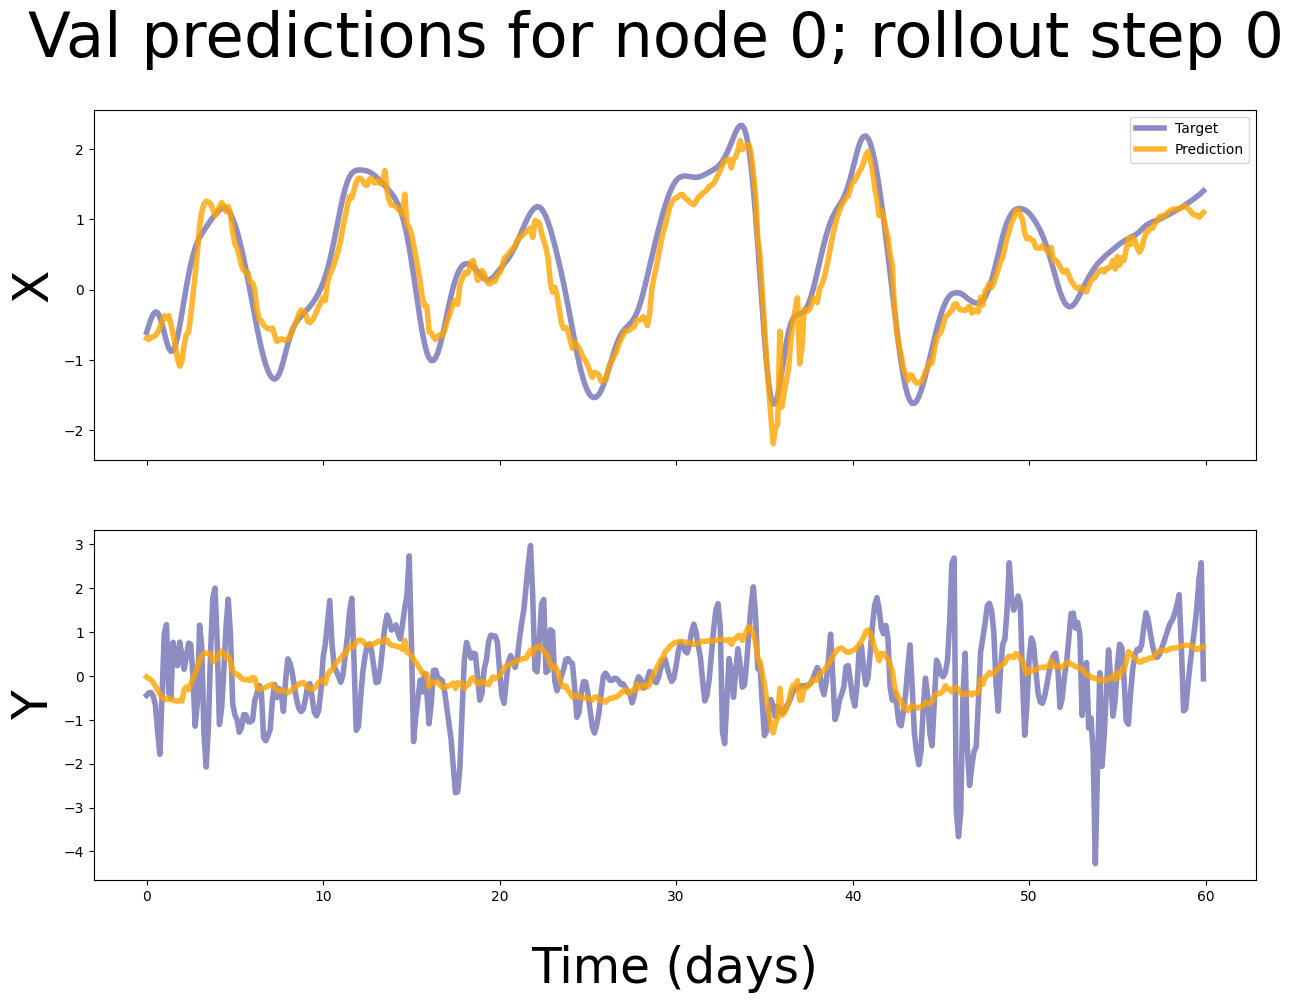

In [21]:
plot_predictions(
    config=config,
    workdir=workdir,
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=x1_x2_same,
    plot_days=60, 
)

### THOUGHTS

when x1 and x2 are similar, x2 performs quite well!